In [1]:
import pandas as pd
import json, random, torch, os, torchvision
from facenet_pytorch import InceptionResnetV1
from PIL import Image
from tqdm import tqdm

Try to make clusters out of the faces so they can be splitted later on between train and validation

**Extract embeddings and cluster faces**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [3]:
base_df = pd.read_csv('data/balance_dataset.csv')

In [4]:
tf_img = lambda i: torchvision.transforms.ToTensor()(i).unsqueeze(0)

In [5]:
df = base_df.drop_duplicates(subset=['video'], ignore_index=True)

In [6]:
faces = df.path.tolist()
embeddings = []

for face in faces:
    with torch.no_grad():
        embedding = resnet(tf_img(Image.open(face)).to(device)).cpu().tolist()[0]
    embeddings.append(embedding)

In [7]:
df['embedding'] = pd.Series(embeddings)

/home/gim/torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df.head(10)

Unnamed: 0           video label                                   path  \
0           0  vpmyeepbep.mp4  REAL  data/faces/chunk0/vpmyeepbep_24_0.png   
1           4  fzvpbrzssi.mp4  REAL  data/faces/chunk0/fzvpbrzssi_14_0.png   
2           8  syxobtuucp.mp4  REAL  data/faces/chunk0/syxobtuucp_14_0.png   
3          12  dhjnjkzuhq.mp4  REAL  data/faces/chunk0/dhjnjkzuhq_23_0.png   
4          16  xcruhaccxc.mp4  REAL   data/faces/chunk0/xcruhaccxc_0_0.png   
5          20  vtunvalyji.mp4  REAL   data/faces/chunk0/vtunvalyji_5_0.png   
6          24  qyqufaskjs.mp4  REAL  data/faces/chunk0/qyqufaskjs_30_0.png   
7          28  rnpefxwptv.mp4  REAL  data/faces/chunk0/rnpefxwptv_17_0.png   
8          32  sttnfyptum.mp4  REAL   data/faces/chunk0/sttnfyptum_6_0.png   
9          36  xugmhbetrw.mp4  REAL  data/faces/chunk0/xugmhbetrw_26_0.png   

   label2                                          embedding  
0       0  [-0.06308822333812714, 0.02556159719824791, -0...  
1       0  [-0.0373431071639061, 0.0013709313934668899, -...  
2       0  [0.05307265371084213, -0.016572482883930206, -...  
3       0  [-0.06234273314476013, -0.012909065932035446, ...  
4       0  [-0.038200635462999344, -0.007039698306471109,...  
5       0  [0.02194514311850071, -0.008131520822644234, -...  
6       0  [0.0029495626222342253, 0.009214987978339195, ...  
7       0  [-0.05334821715950966, -0.03393464908003807, -...  
8       0  [-0.00495421327650547, 0.01055087149143219, -0...  
9       0  [-0.04351823031902313, 0.007019301876425743, -...

**Primary Component Analysis (PCA)**

Done


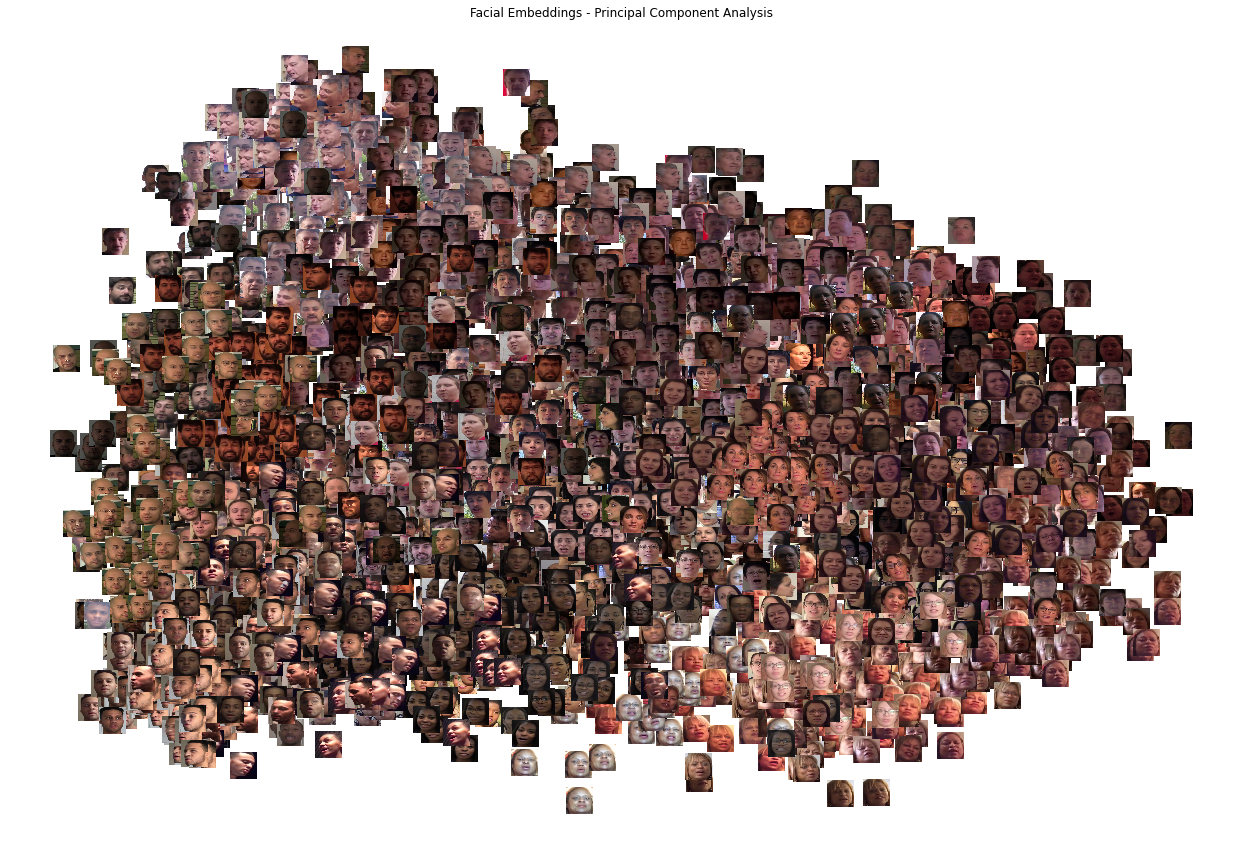

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_thumbnails(data, images, zoom=0.12, colors=None):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data
        
    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    # add thumbnails :)
    for i in range(len(images)):
        image = plt.imread(images[i])
        im = OffsetImage(image, zoom=zoom)
        bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
        ab = AnnotationBbox(im, x[i], xycoords='data', frameon=(bboxprops is not None), pad=0.02, bboxprops=bboxprops)
        ax.add_artist(ab)
    return ax

_ = scatter_thumbnails(df.embedding.tolist(), faces)
plt.title('Facial Embeddings - Principal Component Analysis')
plt.show()

Done


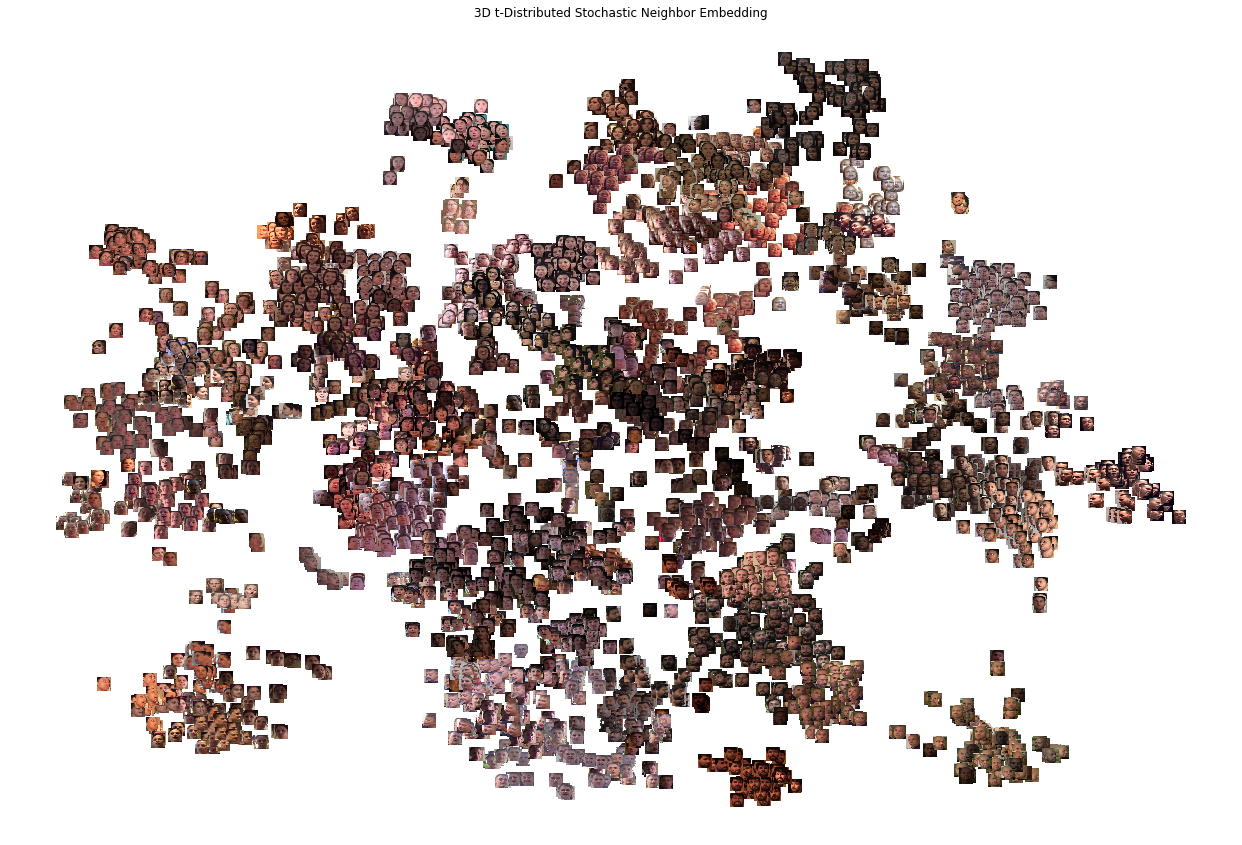

CPU times: user 2min 44s, sys: 2.29 s, total: 2min 46s
Wall time: 1min 13s


In [12]:
%%time
from sklearn.manifold import TSNE
# PCA first to speed it up
x = PCA(n_components=50).fit_transform(df['embedding'].tolist())
x = TSNE(perplexity=50, n_components=3).fit_transform(x)

_ = scatter_thumbnails(x, faces, zoom=0.06)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()

Done


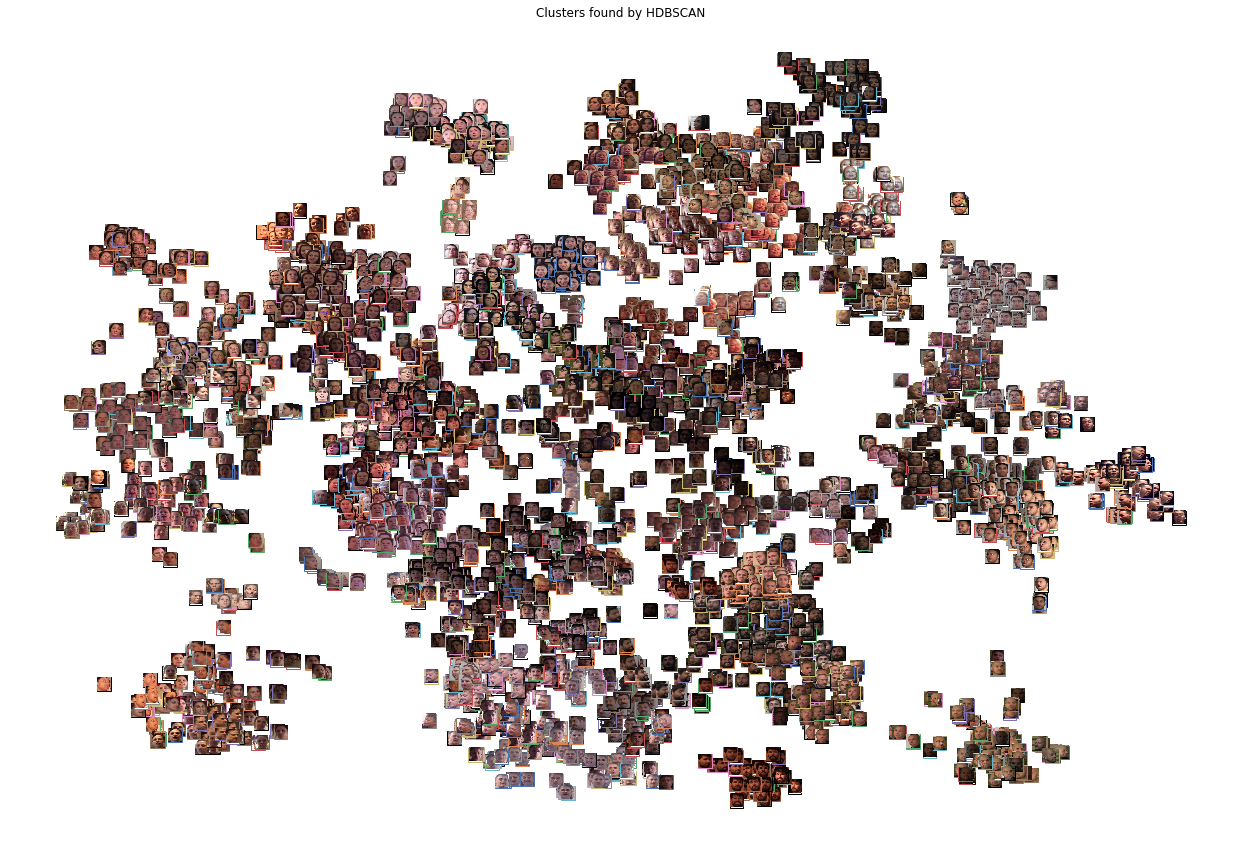

In [60]:
from sklearn import cluster
import hdbscan
def plot_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.max(labels) + 1)
    colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
    ax = scatter_thumbnails(x, df.path.tolist(), zoom=0.06, colors=colors)
    plt.title(f'Clusters found by {algorithm.__name__}')
    return labels

clusters = plot_clusters(x, hdbscan.HDBSCAN, alpha=0.5, min_cluster_size=2, min_samples=1)
#clusters = plot_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=2, min_samples=1)
df['cluster'] = clusters

In [76]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
res_df = df.drop(columns=['label', 'label2', 'embedding', 'path']).sort_values(by='cluster', kind='quicksort')

In [77]:
res_df.sort_values(by='cluster')

video  cluster
3907  uqaaspbgtz.mp4       -1
23    gcdtglsoqj.mp4       -1
1098  uqzgyxstct.mp4       -1
25    upmgtackuf.mp4       -1
2189  ovxqacozqb.mp4       -1
...              ...      ...
2724  frwpjswdnr.mp4     1204
3254  uprxolxcqf.mp4     1204
2714  vgxfdvtnic.mp4     1204
3054  wlbspibmfg.mp4     1205
2741  yyaejjkbds.mp4     1205

[4402 rows x 2 columns]

In [81]:
base_df.set_index(['video'])
v = res_df.set_index(['video'])

In [83]:
v.head(10)

cluster
video                  
uqaaspbgtz.mp4       -1
fwiyjcfwta.mp4       -1
vgorklvyph.mp4       -1
todvzqzwit.mp4       -1
egkaufznwj.mp4       -1
bspvtixfud.mp4       -1
baxkmsihqv.mp4       -1
anrgplirit.mp4       -1
dskfqergbt.mp4       -1
mjarwdrxkt.mp4       -1

In [86]:
v[v.index == 'bgeacsngmi.mp4']

cluster
video                  
bgeacsngmi.mp4       -1

In [89]:
z = base_df.join(v, on='video').sort_values(by='cluster')
z['label'] = z['label2']
z.drop(columns=['label2'])

Unnamed: 0           video  label  \
9687         9687  bgeacsngmi.mp4      0   
1626         1626  rzljiqidhj.mp4      0   
1627         1627  rzljiqidhj.mp4      0   
12576       12576  yoqqryxlll.mp4      0   
12577       12577  yoqqryxlll.mp4      0   
...           ...             ...    ...   
12083       12083  yyaejjkbds.mp4      0   
13444       13444  wlbspibmfg.mp4      1   
13447       13447  wlbspibmfg.mp4      1   
13446       13446  wlbspibmfg.mp4      1   
13445       13445  wlbspibmfg.mp4      1   

                                        path  cluster  
9687   data/faces/chunk6/bgeacsngmi_11_0.png       -1  
1626    data/faces/chunk2/rzljiqidhj_0_0.png       -1  
1627   data/faces/chunk2/rzljiqidhj_14_0.png       -1  
12576   data/faces/chunk7/yoqqryxlll_1_0.png       -1  
12577  data/faces/chunk7/yoqqryxlll_11_0.png       -1  
...                                      ...      ...  
12083  data/faces/chunk7/yyaejjkbds_31_0.png     1205  
13444  data/faces/chunk7/wlbspibmfg_16_0.png     1205  
13447  data/faces/chunk7/wlbspibmfg_12_0.png     1205  
13446  data/faces/chunk7/wlbspibmfg_25_0.png     1205  
13445  data/faces/chunk7/wlbspibmfg_30_0.png     1205  

[19376 rows x 5 columns]

In [103]:
res = z.drop(columns=['label2'])
res.loc[:, ~res.columns.str.contains('^Unnamed')].sort_values(by=['cluster', 'video'])
res.to_csv('ob_dataset.csv', index=False, columns=['video', 'label', 'path'])